In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import CubicSpline
import flygym.mujoco
import flygym.mujoco.preprogrammed
from tqdm import trange
from pathlib import Path

import itertools

output_path = Path("./outputs")
output_path.mkdir(exist_ok=True)

In [2]:
def calculate_ddt(theta, r, w, phi, nu, R, alpha):
    """Given the current state variables theta, r and network parameters
    w, phi, nu, R, alpha, calculate the time derivatives of theta and r."""
    intrinsic_term = 2 * np.pi * nu
    phase_diff = theta[np.newaxis, :] - theta[:, np.newaxis]
    coupling_term = (r * w * np.sin(phase_diff - phi)).sum(axis=1)
    dtheta_dt = intrinsic_term + coupling_term
    dr_dt = alpha * (R - r)
    return dtheta_dt, dr_dt

class CPGNetwork:
    def __init__(
        self,
        timestep,
        intrinsic_freqs,
        intrinsic_amps,
        coupling_weights,
        phase_biases,
        convergence_coefs,
        init_phases=None,
        init_magnitudes=None,
        seed=0,
    ) -> None:
        """Initialize a CPG network consisting of N oscillators.

        Parameters
        ----------
        timestep : float
            The timestep of the simulation.
        intrinsic_frequencies : np.ndarray
            The intrinsic frequencies of the oscillators, shape (N,).
        intrinsic_amplitudes : np.ndarray
            The intrinsic amplitude of the oscillators, shape (N,).
        coupling_weights : np.ndarray
            The coupling weights between the oscillators, shape (N, N).
        phase_biases : np.ndarray
            The phase biases between the oscillators, shape (N, N).
        convergence_coefs : np.ndarray
            Coefficients describing the rate of convergence to oscillator
            intrinsic amplitudes, shape (N,).
        init_phases : np.ndarray, optional
            Initial phases of the oscillators, shape (N,). The phases are
            randomly initialized if not provided.
        init_magnitudes : np.ndarray, optional
            Initial magnitudes of the oscillators, shape (N,). The
            magnitudes are randomly initialized if not provided.
        seed : int, optional
            The random seed to use for initializing the phases and
            magnitudes.
        """
        self.timestep = timestep
        self.num_cpgs = intrinsic_freqs.size
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.coupling_weights = coupling_weights
        self.phase_biases = phase_biases
        self.convergence_coefs = convergence_coefs
        self.random_state = np.random.RandomState(seed)

        self.reset(init_phases, init_magnitudes)

        # Check if the parameters have the right shape
        assert intrinsic_freqs.shape == (self.num_cpgs,)
        assert coupling_weights.shape == (self.num_cpgs, self.num_cpgs)
        assert phase_biases.shape == (self.num_cpgs, self.num_cpgs)
        assert convergence_coefs.shape == (self.num_cpgs,)
        assert self.curr_phases.shape == (self.num_cpgs,)
        assert self.curr_magnitudes.shape == (self.num_cpgs,)

    def step(self):
        """Integrate the ODEs using Euler's method."""
        dtheta_dt, dr_dt = calculate_ddt(
            theta=self.curr_phases,
            r=self.curr_magnitudes,
            w=self.coupling_weights,
            phi=self.phase_biases,
            nu=self.intrinsic_freqs,
            R=self.intrinsic_amps,
            alpha=self.convergence_coefs,
        )
        self.curr_phases += dtheta_dt * self.timestep
        self.curr_magnitudes += dr_dt * self.timestep

    def reset(self, init_phases=None, init_magnitudes=None):
        """Reset the phases and magnitudes of the oscillators."""
        if init_phases is None:
            self.curr_phases = self.random_state.random(self.num_cpgs) * 2 * np.pi
        else:
            self.curr_phases = init_phases

        if init_magnitudes is None:
            self.curr_magnitudes = (
                self.random_state.random(self.num_cpgs) * self.intrinsic_amps
            )
        else:
            self.curr_magnitudes = init_magnitudes

In [3]:
base_path = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/single_step_datasets/")
dofs_per_leg = [
        "Coxa",
        "Coxa_roll",
        "Coxa_yaw",
        "Femur",
        "Femur_roll",
        "Tibia",
        "Tarsus1",
    ]
legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]

def get_stepping_data(filename):
    with open(base_path / filename, "rb") as f:
        single_steps_data = pickle.load(f)
    
    preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
    preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]

    #Check that the data is consistent
    for k, v in single_steps_data.items():
        if k.startswith("joint_"):
            assert len(v) == preprogrammed_steps_length
            #assert v[0] == v[-1]

    # Interpolate the data
    phase_grid = np.linspace(0, 2 * np.pi, preprogrammed_steps_length)
    psi_funcs = {}
    for leg in legs:
        joint_angles = np.array(
            [single_steps_data[f"joint_{leg}{dof}"] for dof in dofs_per_leg]
        )
        
        psi_funcs[leg] = CubicSpline(phase_grid, joint_angles, axis=1, bc_type="periodic")

        theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)

    joint_angles_by_leg = {}
    for leg, psi_func in psi_funcs.items():
        joint_angles_by_leg[leg] = psi_func(theta_ts)

    swing_start = np.empty(6)
    swing_end = np.empty(6)
    for i, leg in enumerate(legs):
        swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
        swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
    swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_start *= 2 * np.pi
    swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_end *= 2 * np.pi

    # have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
    psi_rest_phases = np.ones_like(swing_start)
    for i, leg in enumerate(legs):
        psi_rest_phases[i] = (swing_end[i] + 2*np.pi) / 2
    
    return psi_funcs, psi_rest_phases    

In [4]:
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 100


# Multiple seeds with different files and mirrored

In [5]:
run_time = 5.0
cam_name = "Animat/camera_left"

mirrored = False

fly_trajs = []
exp_names = []

filenames = ["RF_0stance_RM_0stance_RH_0stance.pkl",
                 "RF_0stance_RM_0swing_LH_0stance.pkl",
                 "RF_0stance_RM_0swing_LH_1stance.pkl",
                 "RF_0stance_RM_0swing_LH_0swing.pkl",
                 "RF_1swing_RM_0stance_LH_0stance.pkl",
                 "RF_1swing_RM_0swing_LH_0stance.pkl",
                 ]

"""filenames = ["RF_0stance_RM_0stance_RH_0stance.pkl",
                 "RF_0stance_RM_0swing_LH_0stance.pkl",
                 "RF_0stance_RM_0swing_LH_1stance.pkl",]"""

xmls = ["seqik", "seqik_old"]
xml_alias = ["symmetrical xml", "base xml"]

for xml in xmls:
    for filename in filenames:
        for mirrored in [True, False]:
            for seed in [0, 1, 2]:
                psi_funcs, psi_rest_phases = get_stepping_data(filename)
                np.random.seed(seed)

                fly_traj = []

                sim_params = flygym.mujoco.Parameters(
                    timestep=1e-4,
                    render_mode="headless",
                    render_playspeed=0.1,
                    enable_adhesion=False,  # THIS HAS CHANGED
                    render_camera=cam_name,
                )

                nmf = flygym.mujoco.NeuroMechFly(
                    sim_params=sim_params,
                    init_pose="stretch",
                    actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
                    control="position",
                    xml_variant=xml
                )

                cpg_network = CPGNetwork(
                    timestep=1e-4,
                    intrinsic_freqs=intrinsic_freqs,
                    intrinsic_amps=intrinsic_amps,
                    coupling_weights=coupling_weights,
                    phase_biases=phase_biases,
                    convergence_coefs=convergence_coefs,
                    seed=seed)
                
                cpg_network.random_state = np.random.RandomState(seed)
                cpg_network.reset()
                obs, info = nmf.reset()

                for i in trange(int(run_time / sim_params.timestep)):
                    cpg_network.step()
                    joints_angles = {}
                    for i, leg in enumerate(legs):
                        if mirrored:
                            cpg_phases = cpg_network.curr_phases[::-1]
                        else:
                            cpg_phases = cpg_network.curr_phases

                        psi = psi_funcs[leg](cpg_phases[i])
                        psi_base = psi_funcs[leg](psi_rest_phases[i])
                        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                        for dof, angle in zip(dofs_per_leg, adjusted_psi):
                            joints_angles[f"joint_{leg}{dof}"] = angle
                    
                    action = {
                        "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                    }
                    try:
                        obs, reward, terminated, truncated, info = nmf.step(action)
                    except Exception as e:
                        print(e)
                        break
                    #nmf.render()

                    fly_traj.append(obs["fly"][0][:2])

            
                print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
                fly_trajs.append(fly_traj)
                exp_names.append(f"{seed}_mirrored{mirrored}_filename{filename}_xml{xml}")

100%|██████████| 50000/50000 [00:55<00:00, 901.67it/s]


70.21279907226562 -0.41694918274879456


100%|██████████| 50000/50000 [00:55<00:00, 900.69it/s]


69.68878173828125 0.37118449807167053


100%|██████████| 50000/50000 [00:54<00:00, 912.61it/s]


69.83765411376953 0.436642050743103


100%|██████████| 50000/50000 [00:54<00:00, 913.59it/s]


70.13343048095703 1.2799235582351685


100%|██████████| 50000/50000 [01:02<00:00, 806.38it/s]


69.96664428710938 -0.07333062589168549


100%|██████████| 50000/50000 [00:57<00:00, 871.34it/s]


70.1935043334961 -0.7789696455001831


100%|██████████| 50000/50000 [02:27<00:00, 339.18it/s] 


66.86502838134766 -2.485257148742676


100%|██████████| 50000/50000 [01:29<00:00, 558.66it/s]


66.40803527832031 -0.4589068591594696


100%|██████████| 50000/50000 [02:21<00:00, 352.92it/s] 


66.72679901123047 2.223193645477295


100%|██████████| 50000/50000 [02:06<00:00, 394.65it/s] 


66.41263580322266 5.180708885192871


100%|██████████| 50000/50000 [01:43<00:00, 482.32it/s] 


66.74169158935547 1.8650405406951904


100%|██████████| 50000/50000 [02:18<00:00, 359.75it/s] 


66.56736755371094 -1.8648961782455444


100%|██████████| 50000/50000 [01:03<00:00, 784.73it/s]


67.42291259765625 -0.8504722714424133


100%|██████████| 50000/50000 [01:14<00:00, 672.77it/s]


67.3150863647461 0.21282976865768433


100%|██████████| 50000/50000 [01:15<00:00, 665.13it/s]


67.4640121459961 0.13880842924118042


100%|██████████| 50000/50000 [03:49<00:00, 218.20it/s] 


67.75981903076172 0.9159502983093262


100%|██████████| 50000/50000 [01:31<00:00, 544.12it/s]


67.64362335205078 0.6345733404159546


100%|██████████| 50000/50000 [01:41<00:00, 494.25it/s] 


67.30177307128906 -0.30696219205856323


100%|██████████| 50000/50000 [00:59<00:00, 837.56it/s]


68.85254669189453 -0.7419273853302002


100%|██████████| 50000/50000 [00:59<00:00, 834.69it/s]


68.67182159423828 0.5231420397758484


100%|██████████| 50000/50000 [00:59<00:00, 837.46it/s]


68.6539535522461 -0.757782518863678


100%|██████████| 50000/50000 [00:59<00:00, 844.07it/s]


68.45671081542969 0.2056610882282257


100%|██████████| 50000/50000 [01:00<00:00, 830.09it/s]


68.66679382324219 0.42967304587364197


100%|██████████| 50000/50000 [00:59<00:00, 840.91it/s]


68.64215850830078 -1.0935481786727905


100%|██████████| 50000/50000 [00:57<00:00, 862.56it/s]


38.17397689819336 -0.9829779267311096


100%|██████████| 50000/50000 [00:56<00:00, 877.62it/s]


37.707359313964844 -0.4674672484397888


100%|██████████| 50000/50000 [00:55<00:00, 901.86it/s]


37.798912048339844 -0.9348633289337158


100%|██████████| 50000/50000 [00:56<00:00, 879.72it/s]


38.08950424194336 0.7891880869865417


100%|██████████| 50000/50000 [00:56<00:00, 892.84it/s]


37.574134826660156 -1.3593368530273438


100%|██████████| 50000/50000 [00:55<00:00, 900.04it/s]


38.13728713989258 -0.1707025021314621


100%|██████████| 50000/50000 [00:55<00:00, 893.68it/s]


28.592437744140625 -0.6732750535011292


100%|██████████| 50000/50000 [00:55<00:00, 894.85it/s]


28.85489273071289 -0.272079735994339


100%|██████████| 50000/50000 [00:56<00:00, 882.80it/s]


28.776931762695312 -0.21678435802459717


100%|██████████| 50000/50000 [00:56<00:00, 887.31it/s]


28.564197540283203 0.08749943226575851


100%|██████████| 50000/50000 [00:56<00:00, 886.74it/s]


29.1279354095459 -0.3761085569858551


100%|██████████| 50000/50000 [00:59<00:00, 836.12it/s]


28.68998146057129 -0.0989493653178215


100%|██████████| 50000/50000 [01:23<00:00, 596.68it/s]


66.60871124267578 -1.6006977558135986


100%|██████████| 50000/50000 [01:22<00:00, 603.26it/s]


65.38260650634766 -0.7241669297218323


100%|██████████| 50000/50000 [01:21<00:00, 616.09it/s]


65.53564453125 -1.2550090551376343


100%|██████████| 50000/50000 [01:22<00:00, 605.96it/s]


66.12329864501953 -0.45193177461624146


100%|██████████| 50000/50000 [01:26<00:00, 577.84it/s]


64.82070922851562 -2.422828197479248


100%|██████████| 50000/50000 [01:21<00:00, 612.12it/s]


65.4845199584961 -2.2949390411376953


100%|██████████| 50000/50000 [02:12<00:00, 378.01it/s]


64.65481567382812 -25.39714813232422


100%|██████████| 50000/50000 [02:13<00:00, 374.67it/s]


68.45680236816406 7.228600025177002


100%|██████████| 50000/50000 [02:12<00:00, 376.23it/s]


54.10883712768555 45.87257766723633


100%|██████████| 50000/50000 [02:10<00:00, 383.42it/s]


-12.599193572998047 52.29652786254883


100%|██████████| 50000/50000 [02:14<00:00, 371.69it/s]


59.35003662109375 40.066322326660156


100%|██████████| 50000/50000 [02:16<00:00, 366.98it/s]


57.19630813598633 43.24072265625


100%|██████████| 50000/50000 [02:18<00:00, 361.34it/s]


65.59004974365234 -12.788810729980469


100%|██████████| 50000/50000 [02:12<00:00, 377.48it/s]


63.69382858276367 -17.588218688964844


100%|██████████| 50000/50000 [02:18<00:00, 362.00it/s]


58.89886474609375 -28.609663009643555


100%|██████████| 50000/50000 [02:15<00:00, 368.50it/s]


66.05631256103516 -10.47751235961914


100%|██████████| 50000/50000 [02:14<00:00, 372.03it/s]


64.79386138916016 -16.257862091064453


100%|██████████| 50000/50000 [02:14<00:00, 371.72it/s]


45.2269287109375 -43.738948822021484


100%|██████████| 50000/50000 [02:03<00:00, 406.11it/s]


61.03260040283203 27.732406616210938


100%|██████████| 50000/50000 [02:04<00:00, 400.29it/s]


56.51728820800781 31.264982223510742


100%|██████████| 50000/50000 [02:09<00:00, 385.43it/s]


49.088714599609375 29.526865005493164


100%|██████████| 50000/50000 [02:04<00:00, 402.67it/s]


42.719146728515625 39.84173583984375


100%|██████████| 50000/50000 [02:06<00:00, 395.09it/s]


12.63148021697998 56.827266693115234


100%|██████████| 50000/50000 [02:08<00:00, 390.41it/s]


68.29765319824219 12.384175300598145


100%|██████████| 50000/50000 [02:14<00:00, 372.79it/s]


34.20884323120117 22.352313995361328


100%|██████████| 50000/50000 [02:02<00:00, 408.58it/s]


3.0526952743530273 -0.6785169839859009


100%|██████████| 50000/50000 [02:03<00:00, 404.97it/s]


2.3982162475585938 -4.230484962463379


100%|██████████| 50000/50000 [02:10<00:00, 381.86it/s]


31.554454803466797 28.813962936401367


100%|██████████| 50000/50000 [02:14<00:00, 371.15it/s]


31.74544334411621 -28.82823944091797


100%|██████████| 50000/50000 [02:09<00:00, 385.81it/s]


-3.9637680053710938 30.583335876464844


100%|██████████| 50000/50000 [02:08<00:00, 389.74it/s]


28.058815002441406 -15.80968189239502


100%|██████████| 50000/50000 [02:09<00:00, 387.12it/s]


16.993492126464844 -24.21162986755371


100%|██████████| 50000/50000 [02:07<00:00, 391.22it/s]


34.83967590332031 5.4990386962890625


100%|██████████| 50000/50000 [02:08<00:00, 389.20it/s]


31.82931900024414 -11.378700256347656


100%|██████████| 50000/50000 [02:08<00:00, 388.50it/s]


16.536056518554688 -25.797456741333008


100%|██████████| 50000/50000 [02:08<00:00, 388.83it/s]

23.138141632080078 -20.674335479736328


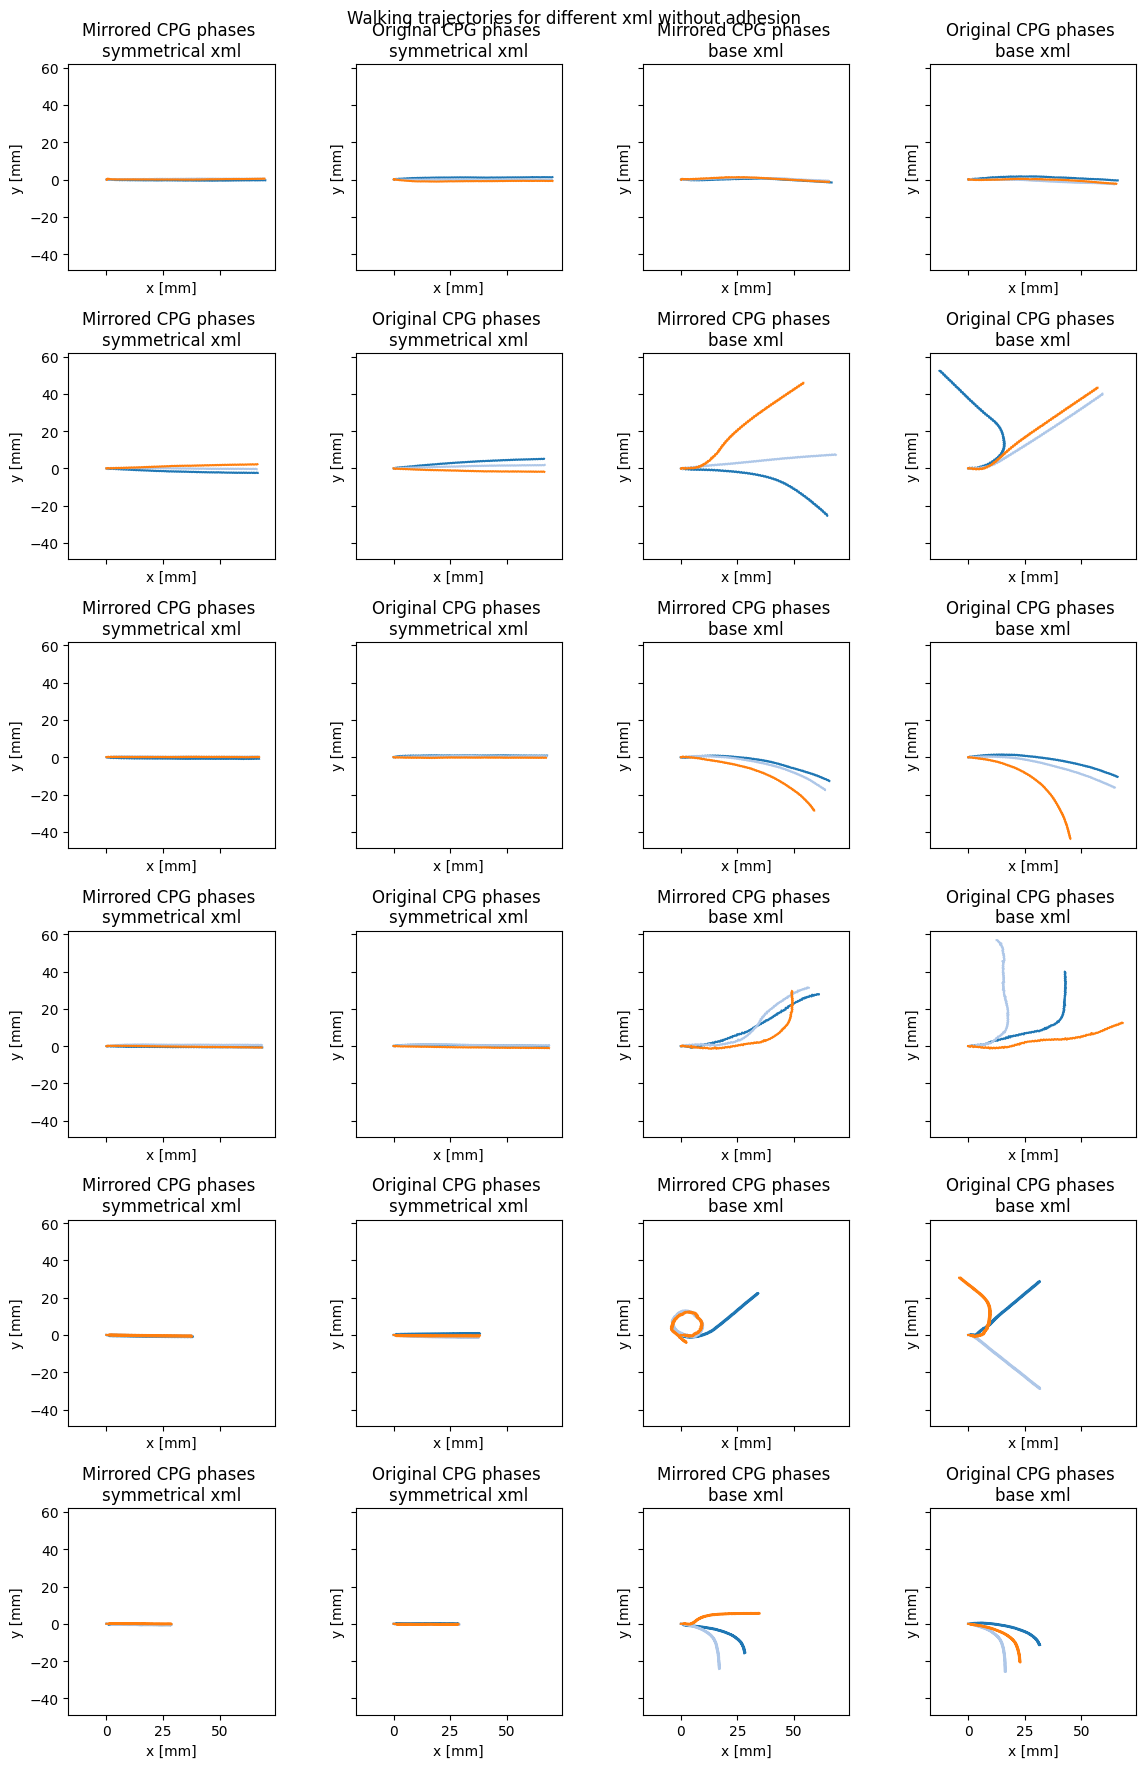

In [8]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
subplot_height = 3
n_rows = len(filenames)
n_cols = len(xmls)*2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_height, n_rows * subplot_height), sharex=True, sharey=True)  
colors = plt.cm.tab20.colors

color_map = {}
color_counter = np.zeros(np.shape(axs), dtype=int)
title_list = []

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    param_val = exp_names[i].split("_")[0]

    filename_index = exp_names[i].find("filename") + len("filename")
    xml_index = exp_names[i].find("_xml")
    xml_end_index = exp_names[i].find("_xml") + len("_xml")
    
    exp_filename = exp_names[i][filename_index:xml_index]
    plot_row = filenames.index(exp_filename)
    plot_col = 0 if "True" in exp_names[i] else 1
    plot_col += 2*xmls.index(exp_names[i][xml_end_index:])
    
    title = "Mirrored CPG phases " if "True" in exp_names[i] else "Original CPG phases "
    title += "\n" + xml_alias[xmls.index(exp_names[i][xml_end_index:])]
    
    if title not in title_list:
        title_list.append(title)
    
    if param_val not in color_map:
        color_map[param_val] = color_counter[plot_row][plot_col]
        color_counter[plot_row][plot_col] += 1
    color_id = color_map[param_val]

    if len(traj) > 0:
        axs[plot_row][plot_col].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_row][plot_col].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])

axs = axs.flatten()
for i, ax in enumerate(axs):   
    #ax.legend(fontsize=7)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title(title_list[i%len(title_list)])
    ax.set_box_aspect(1)

plt.suptitle("Walking trajectories for different xml without adhesion")
plt.tight_layout()
plt.show()

# Repeat with adhesion

In [ ]:
def get_stepping_data(filename):
    with open(base_path / filename, "rb") as f:
        single_steps_data = pickle.load(f)
    
    preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
    preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]

    #Check that the data is consistent
    for k, v in single_steps_data.items():
        if k.startswith("joint_"):
            assert len(v) == preprogrammed_steps_length
            #assert v[0] == v[-1]

    # Interpolate the data
    phase_grid = np.linspace(0, 2 * np.pi, preprogrammed_steps_length)
    psi_funcs = {}
    for leg in legs:
        joint_angles = np.array(
            [single_steps_data[f"joint_{leg}{dof}"] for dof in dofs_per_leg]
        )
        
        psi_funcs[leg] = CubicSpline(phase_grid, joint_angles, axis=1, bc_type="periodic")

        theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)

    joint_angles_by_leg = {}
    for leg, psi_func in psi_funcs.items():
        joint_angles_by_leg[leg] = psi_func(theta_ts)

    swing_start = np.empty(6)
    swing_end = np.empty(6)
    for i, leg in enumerate(legs):
        swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
        swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
    swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_start *= 2 * np.pi
    swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_end *= 2 * np.pi

    # have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
    psi_rest_phases = np.ones_like(swing_start)
    for i, leg in enumerate(legs):
        psi_rest_phases[i] = (swing_end[i] + 2*np.pi) / 2
    
    swing_start = np.empty(6)
    swing_end = np.empty(6)
    for i, leg in enumerate(legs):
        swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
        swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
    swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_start *= 2 * np.pi
    swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_end *= 2 * np.pi

    # have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
    psi_rest_phases = np.ones_like(swing_start)
    for i, leg in enumerate(legs):
        psi_rest_phases[i] = (swing_end[i] + 2*np.pi) / 2
    
    return psi_funcs, psi_rest_phases, swing_start, swing_end

In [ ]:
def get_adhesion_onoff(theta, swing_start, swing_end):
    theta = theta % (2 * np.pi)
    return ~((theta > swing_start) & (theta < swing_end)).squeeze()

In [ ]:
run_time = 5.0
cam_name = "Animat/camera_left"
kp = 50.0

mirrored = False

fly_trajs = []
exp_names = []

filenames = ["RF_0stance_RM_0stance_RH_0stance.pkl",
                 "RF_0stance_RM_0swing_LH_0swing.pkl",
                 "RF_1swing_RM_0swing_LH_0swing.pkl",
                 ]

xmls = ["seqik", "seqik_old"]
xml_alias = ["symmetrical xml", "base xml"]

for xml in xmls:
    for filename in filenames:
        for mirrored in [True, False]:
            for seed in [0, 1]:
                psi_funcs, psi_rest_phases, swing_start, swing_end = get_stepping_data(filename)
                np.random.seed(seed)

                fly_traj = []

                sim_params = flygym.mujoco.Parameters(
                    timestep=1e-4,
                    render_mode="headless",
                    render_playspeed=0.1,
                    enable_adhesion=True,  # THIS HAS CHANGED
                    draw_adhesion=True,
                    render_camera=cam_name,
                )

                nmf = flygym.mujoco.NeuroMechFly(
                    sim_params=sim_params,
                    init_pose="stretch",
                    actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
                    control="position",
                    xml_variant=xml
                )

                cpg_network = CPGNetwork(
                    timestep=1e-4,
                    intrinsic_freqs=intrinsic_freqs,
                    intrinsic_amps=intrinsic_amps,
                    coupling_weights=coupling_weights,
                    phase_biases=phase_biases,
                    convergence_coefs=convergence_coefs,
                    seed=seed)
                
                cpg_network.random_state = np.random.RandomState(seed)
                cpg_network.reset()
                obs, info = nmf.reset()

                nmf.render()
                for i in trange(int(run_time / sim_params.timestep)):
                    cpg_network.step()
                    joints_angles = {}
                    for i, leg in enumerate(legs):
                        if mirrored:
                            cpg_phases = cpg_network.curr_phases[::-1]
                        else:
                            cpg_phases = cpg_network.curr_phases

                        psi = psi_funcs[leg](cpg_phases[i])
                        psi_base = psi_funcs[leg](psi_rest_phases[i])
                        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                        for dof, angle in zip(dofs_per_leg, adjusted_psi):
                            joints_angles[f"joint_{leg}{dof}"] = angle
                    adhesion_onoff = get_adhesion_onoff(cpg_phases, swing_start, swing_end)
                    action = {
                        "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                        ##### THIS LINE IS NEW #####
                        "adhesion": adhesion_onoff.astype(int),
                        ############################
                    }
                    try:
                        obs, reward, terminated, truncated, info = nmf.step(action)
                    except Exception as e:
                        print(e)
                        break
                    #nmf.render()

                    fly_traj.append(obs["fly"][0][:2])
                video_path = Path(f"./outputs/{seed}_mirrored{mirrored}_filename{filename}_xml{xml}.mp4")
                #nmf.save_video(video_path, 0)
            
                print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
                fly_trajs.append(fly_traj)
                exp_names.append(f"{seed}_mirrored{mirrored}_filename{filename}_xml{xml}")

100%|██████████| 50000/50000 [01:15<00:00, 664.86it/s]


71.28323364257812 -7.657564163208008


100%|██████████| 50000/50000 [01:15<00:00, 661.29it/s]


71.72341918945312 -0.19072820246219635


100%|██████████| 50000/50000 [01:13<00:00, 679.32it/s]


70.43484497070312 12.478117942810059


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.01634914241731167 0.0073094856925308704


100%|██████████| 50000/50000 [01:31<00:00, 546.02it/s]


66.30622863769531 -5.322631359100342


100%|██████████| 50000/50000 [01:32<00:00, 541.74it/s]


66.30792236328125 -2.0804355144500732


100%|██████████| 50000/50000 [01:32<00:00, 538.17it/s]


62.33474349975586 20.06256866455078


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.01634914241731167 0.0073094856925308704


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.01634914241731167 0.0073094856925308704


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.01634914241731167 0.0073094856925308704


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.01634914241731167 0.0073094856925308704


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.01634914241731167 0.0073094856925308704


100%|██████████| 50000/50000 [01:40<00:00, 497.94it/s]


69.56047058105469 -12.736387252807617


100%|██████████| 50000/50000 [01:40<00:00, 499.43it/s]


68.99169158935547 -13.422362327575684


100%|██████████| 50000/50000 [01:40<00:00, 499.45it/s]


70.50437927246094 -0.3396073579788208


100%|██████████| 50000/50000 [01:42<00:00, 490.04it/s]


69.00982666015625 -10.569318771362305


100%|██████████| 50000/50000 [02:37<00:00, 317.56it/s]


61.187740325927734 -39.40666961669922


100%|██████████| 50000/50000 [02:40<00:00, 310.83it/s]


59.40188980102539 39.946632385253906


100%|██████████| 50000/50000 [02:41<00:00, 309.66it/s]


61.67824172973633 37.58015823364258


100%|██████████| 50000/50000 [02:34<00:00, 323.12it/s]


62.24720001220703 -37.088966369628906


100%|██████████| 50000/50000 [02:28<00:00, 337.57it/s]


33.84733581542969 -51.38996887207031


100%|██████████| 50000/50000 [02:27<00:00, 339.64it/s]


13.584710121154785 -42.81479263305664


100%|██████████| 50000/50000 [02:27<00:00, 338.31it/s]


43.0786247253418 -35.31914520263672


  0%|          | 0/50000 [00:00<?, ?it/s]

Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


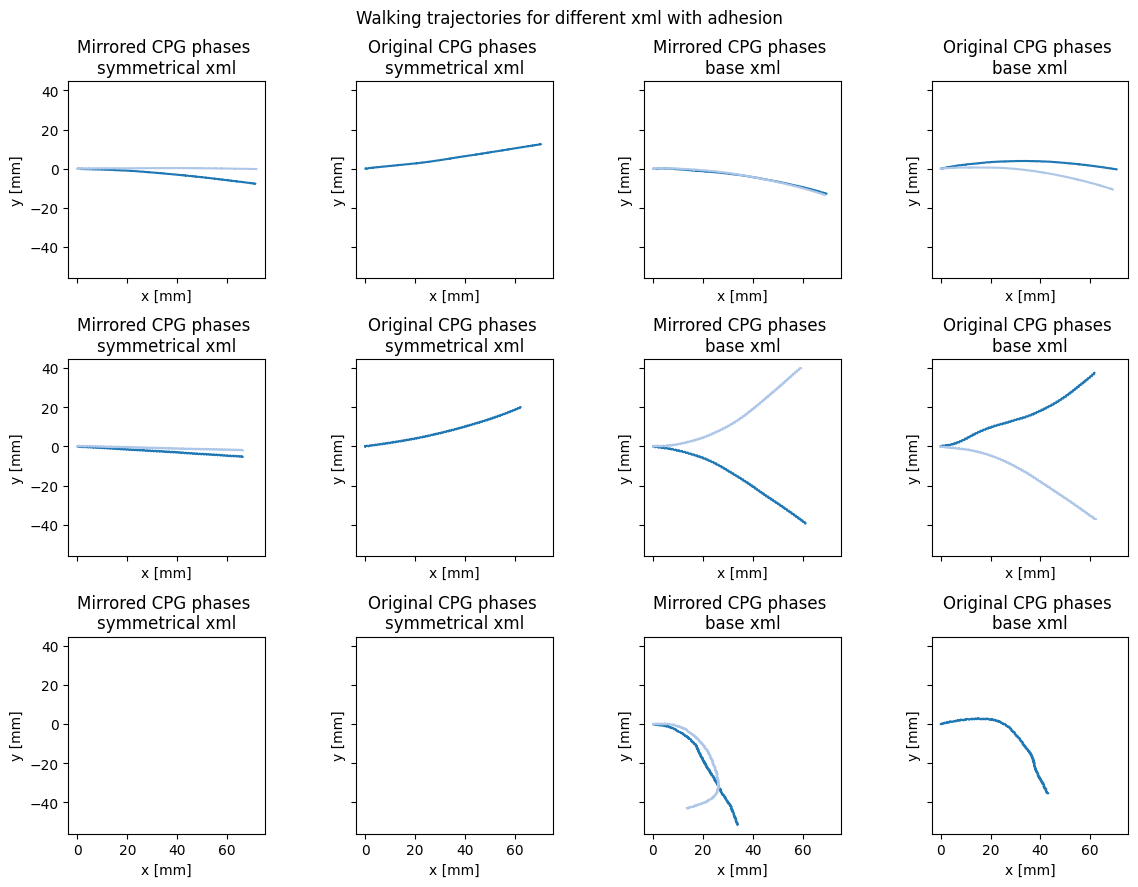

In [ ]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
subplot_height = 3
n_rows = len(filenames)
n_cols = len(xmls)*2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_height, n_rows * subplot_height), sharex=True, sharey=True)  
colors = plt.cm.tab20.colors

color_map = {}
color_counter = np.zeros(np.shape(axs), dtype=int)
title_list = []

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    param_val = exp_names[i].split("_")[0]

    filename_index = exp_names[i].find("filename") + len("filename")
    xml_index = exp_names[i].find("_xml")
    xml_end_index = exp_names[i].find("_xml") + len("_xml")
    
    exp_filename = exp_names[i][filename_index:xml_index]
    plot_row = filenames.index(exp_filename)
    plot_col = 0 if "True" in exp_names[i] else 1
    plot_col += xmls.index(exp_names[i][xml_end_index:])*2
    
    title = "Mirrored CPG phases " if "True" in exp_names[i] else "Original CPG phases "
    
    title += "\n" + xml_alias[xmls.index(exp_names[i][xml_end_index:])]
    
    if title not in title_list:
        title_list.append(title)
    
    if param_val not in color_map:
        color_map[param_val] = color_counter[plot_row][plot_col]
        color_counter[plot_row][plot_col] += 1
    color_id = color_map[param_val]

    if len(traj) > 0:
        axs[plot_row][plot_col].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_row][plot_col].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])

axs = axs.flatten()
for i, ax in enumerate(axs):   
    #ax.legend(fontsize=7)
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title(title_list[i%len(title_list)])
    ax.set_box_aspect(1)

plt.suptitle("Walking trajectories for different xml with adhesion")
plt.tight_layout()
plt.show()